In [1]:
from __future__ import annotations
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Optional, Sequence, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import scqubits as scq
import floquet as ft
from scipy.optimize import linear_sum_assignment
import os
import json
import pickle
import pandas as pd

In [2]:
# asked claude to add these utility functions for saving data!!!!

def ensure_dir(path: str) -> None:
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def save_dict_json(data: dict, path: str) -> None:
    """Save dict to JSON (for simple types only)."""
    ensure_dir(os.path.dirname(path) or ".")
    # Convert numpy types to native Python types
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        if isinstance(obj, (np.int32, np.int64)):
            return int(obj)
        if isinstance(obj, dict):
            return {k: convert(v) for k, v in obj.items()}
        if isinstance(obj, (list, tuple)):
            return [convert(v) for v in obj]
        return obj
    with open(path, 'w') as f:
        json.dump(convert(data), f, indent=2)
    print(f"Saved JSON: {path}")

def save_npz(path: str, **arrays) -> None:
    """Save multiple arrays to .npz file."""
    ensure_dir(os.path.dirname(path) or ".")
    np.savez(path, **arrays)
    print(f"Saved NPZ: {path}")

def save_pickle(data, path: str) -> None:
    """Save arbitrary Python object to pickle."""
    ensure_dir(os.path.dirname(path) or ".")
    with open(path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved pickle: {path}")

def save_figure(fig, path: str, dpi: int = 300) -> None:
    """Save matplotlib figure."""
    ensure_dir(os.path.dirname(path) or ".")
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f"Saved figure: {path}")



#to construct orthonormal columns from evecs
def _columns_from_evecs(evecs, cutoff, dim_q):
    if isinstance(evecs, (list, tuple)):
        U = np.column_stack([np.asarray(v).reshape(-1) for v in evecs])
    else:
        M = np.asarray(evecs)
        cols = []
        for vec in (M, M.T):
            if vec.shape == (cutoff, dim_q):
                orthonorm_err = np.linalg.norm(vec.conj().T @ vec - np.eye(dim_q))
                cols.append((orthonorm_err, vec))
        _, U = min(cols, key=lambda x: x[0])
    unitary_err = np.linalg.norm(U.conj().T @ U - np.eye(dim_q))
    if unitary_err > 1e-8:
        raise ValueError(f"projected eig.vectors are not orthonormal; unitary error ={unitary_err}")
    return U

def enforce_hermiticity(H: qt.Qobj) -> qt.Qobj:
    return 0.5 * (H + H.dag())


#organize all configs in dataclasses
@dataclass
class CompositeSysConfig:
    qubit_params: Dict[str, float]
    dim_q: int
    dim_r: int
    omega_r: float
    g: float
    coupling_op: str = "n"
    resonator_quadrature: str = "x"

@dataclass
class BuildComposite:
    cfg: CompositeSysConfig
    model: ft.model.CompositeModel
    dressed_indices: List[int]
    bare_ops: Dict[str, qt.Qobj]
    diag_ops: Dict[str, qt.Qobj]

@dataclass
class BranchData:
    chi_ac: np.ndarray
    omega_d: float
    Nq: np.ndarray
    Nr: np.ndarray
    purity_q: np.ndarray
    labels: np.ndarray
    label_weight: np.ndarray
    quasienergies: np.ndarray
    swap_events: List[Dict[str, object]]

    def save(self, outdir: str, prefix: str = "branch_data") -> None:
        ensure_dir(outdir)
        save_npz(
            os.path.join(outdir, f"{prefix}_arrays.npz"),
            chi_ac=self.chi_ac,
            Nq=self.Nq,
            Nr=self.Nr,
            purity_q=self.purity_q,
            label_weight=self.label_weight,
            quasienergies=self.quasienergies,
        )
        # Labels need special handling (object array)
        save_pickle(self.labels, os.path.join(outdir, f"{prefix}_labels.pkl"))
        # Swap events as JSON
        if self.swap_events:
            save_dict_json(
                {"omega_d": self.omega_d, "swap_events": self.swap_events},
                os.path.join(outdir, f"{prefix}_swap_events.json")
            )
        # Summary CSV
        df = pd.DataFrame({
            "chi_ac_GHz": self.chi_ac / (2 * np.pi),
            "Nq_branch0": self.Nq[:, 0] if self.Nq.shape[1] > 0 else np.nan,
            "Nr_branch0": self.Nr[:, 0] if self.Nr.shape[1] > 0 else np.nan,
            "purity_branch0": self.purity_q[:, 0] if self.purity_q.shape[1] > 0 else np.nan,
        })
        df.to_csv(os.path.join(outdir, f"{prefix}_summary.csv"), index=False)
        print(f"Saved BranchData to {outdir}/{prefix}_*")

@dataclass
class TruncationResult:
    dim_r_list: List[int]
    dim_q_list: List[int]
    comm_error: np.ndarray
    comm_error_analytic: np.ndarray
    p_q_top: np.ndarray
    p_r_top: np.ndarray
    purity_q: np.ndarray
    Nr: np.ndarray

    def save(self, outdir: str, prefix: str = "truncation") -> None:
        ensure_dir(outdir)
        save_npz(
            os.path.join(outdir, f"{prefix}_arrays.npz"),
            dim_q_list=np.array(self.dim_q_list),
            dim_r_list=np.array(self.dim_r_list),
            comm_error=self.comm_error,
            p_q_top=self.p_q_top,
            p_r_top=self.p_r_top,
            purity_q=self.purity_q,
            Nr=self.Nr,
            comm_error_analytic=self.comm_error_analytic,
        )
        print(f"Saved TruncationResult to {outdir}/{prefix}_arrays.npz")


#build the model

def build_fluxonium_eigenbasis(
    qubit_params: Dict[str, float],
    dim_q: int,
    *,
    coupling_op: str = "n",
):
    fluxonium = scq.Fluxonium(**qubit_params, truncated_dim=dim_q)
    evals_GHz, evecs = fluxonium.eigensys(evals_count=dim_q)
    evals_GHz = np.asarray(evals_GHz)

    Hq = 2 * np.pi * qt.Qobj(np.diag(evals_GHz - evals_GHz[0]), dims=[[dim_q], [dim_q]])

    if coupling_op == "n":
        op = fluxonium.n_operator()
    elif coupling_op == "phi":
        op = fluxonium.phi_operator()

    op_arr = np.array(op, dtype=complex)
    cutoff = op_arr.shape[0]
    Uq = _columns_from_evecs(evecs, cutoff, dim_q)
    op_eig = Uq.conj().T @ op_arr @ Uq
    op_eig = enforce_hermiticity(qt.Qobj(op_eig))

    qubit_coupling_op = qt.Qobj(op_eig.full(), dims=[[dim_q], [dim_q]])
    return Hq, qubit_coupling_op, evals_GHz

def resonator_quadrature(a: qt.Qobj, coupling_type: str):
    if coupling_type == "x":
        return (a + a.dag())
    elif coupling_type == "y":
        return -1j * (a - a.dag())

def build_composite_model(
    cfg: CompositeSysConfig,
    omega_d_values: np.ndarray,
    chi_ac_values: np.ndarray,
    *,
    label_states: Sequence[Tuple[int, int]] = ((0, 0), (1, 0))
) -> BuildComposite:
    omega_d_values = np.atleast_1d(np.array(omega_d_values))
    chi_ac_values = np.atleast_1d(np.array(chi_ac_values))
    dim_q = cfg.dim_q
    dim_r = cfg.dim_r

    Hq, n_op, _ = build_fluxonium_eigenbasis(cfg.qubit_params, dim_q, coupling_op=cfg.coupling_op)

    a = qt.destroy(dim_r)
    Iq = qt.qeye(dim_q)
    Ir = qt.qeye(dim_r)
    Xr = resonator_quadrature(a, cfg.resonator_quadrature)

    H_r = cfg.omega_r * qt.tensor(Iq, a.dag() * a)
    H_q = qt.tensor(Hq, Ir)
    H_int = cfg.g * qt.tensor(n_op, Xr)
    H0_bare = enforce_hermiticity(H_q + H_r + H_int)

    H1_drive_bare = enforce_hermiticity(qt.tensor(n_op, Ir))
    placeholder = np.zeros((len(chi_ac_values), len(omega_d_values)), dtype=float)

    model = ft.model.CompositeModel(
        H0_bare=H0_bare,
        H1_drive=H1_drive_bare,
        omega_d_values=omega_d_values,
        drive_amplitudes=placeholder,
        subsystem_dims=(dim_q, dim_r),
        state_labels_dims=(dim_q, dim_r),
    )

    dressed_indices = model.labels_to_indices(list(label_states))
    chi2amp = ft.ChiacToAmp(model.H0, model.H1, dressed_indices, model.omega_d_values)
    model.drive_amplitudes = chi2amp.amplitudes_for_omega_d(chi_ac_values)

    Nq = qt.Qobj(np.diag(np.arange(dim_q)), dims=[[dim_q], [dim_q]])
    Nr = a.dag() * a

    

    ops_bare = {
        "a": qt.tensor(Iq, a),
        "adag": qt.tensor(Iq, a.dag()),
        "Nr": qt.tensor(Iq, Nr),
        "Nq": qt.tensor(Nq, Ir),
        "nq": qt.tensor(n_op, Ir),
        "H0": H0_bare,
        "H1_drive_bare": H1_drive_bare
    }

    U = model.U
    ops_diag = {}
    for name, op in ops_bare.items():
        dressed = U.dag() * op * U
        ops_diag[name] = enforce_hermiticity(dressed) if op.isherm else dressed

    return BuildComposite(
        cfg=cfg,
        model=model,
        dressed_indices=dressed_indices,
        bare_ops=ops_bare,
        diag_ops=ops_diag
    )



#in order to computer purity, entropy, etc., convert from diag basis to bare basis
def _psi_diag_to_bare_matrix(
    model: ft.model.CompositeModel,
    psi_diag: qt.Qobj,
    dim_q: int,
    dim_r: int
) -> np.ndarray:
    U = model.U.full()
    v = psi_diag.full().reshape(-1)
    v_bare = U @ v
    return v_bare.reshape((dim_q, dim_r))

def reduced_qubit_density_matrix(psi_bare_mat):
    return psi_bare_mat @ psi_bare_mat.conj().T

def purity_from_rho(rho):
    return np.real(np.trace(rho @ rho))

def von_neumann_entropy(rho: np.ndarray, *, eps: float = 1e-10):
    weights = np.linalg.eigvalsh(0.5 * (rho + rho.conj().T))
    weights = np.clip(np.real(weights), 0.0, 1.0)
    weights = weights[weights > eps]
    return -np.sum(weights * np.log(weights))

def expectations_from_psi_bare(psi_bare_mat):
    dim_q, dim_r = psi_bare_mat.shape
    p = np.abs(psi_bare_mat) ** 2
    p_q = np.sum(p, axis=1)
    p_r = np.sum(p, axis=0)

    Nq = np.sum(np.arange(dim_q) * p_q)
    Nr = np.sum(np.arange(dim_r) * p_r)

    return {
        "Nq": Nq,
        "Nr": Nr,
        "p_r0": p_r[0],
        "p_r_nonzero": 1 - p_r[0],
        "p_r_top": p_r[-1],
        "p_q_top": p_q[-1],
    }

def commutator_error(dim_r, p_r_top):
    return dim_r * p_r_top


def _as_density_qobj(x: qt.Qobj) -> qt.Qobj:
    """density matrix Qobj from either ket or density matrix"""
    if not isinstance(x, qt.Qobj):
        raise TypeError(f"probably is an array obj. {type(x)}")
    if x.isket:
        return x.proj()
    if x.isoper:
        return x

def _rewrap_with_dims(op: qt.Qobj, dims) -> qt.Qobj:
    """identical matrix entries but ensure dim. matching"""
    return qt.Qobj(op.full(), dims=dims)


def commutator_error_analytic(state_or_rho: qt.Qobj, a: qt.Qobj, mode = "expectation"): #op_norm --> ||aa^† - a^†a - I||_F 
    rho = _as_density_qobj(state_or_rho)
    # Shape check first (actual matrix size)
    if a.shape != rho.shape:
        raise ValueError(
            f"mismatch: a is {a.shape}, rho is {rho.shape}. "
            "check ff you passed a reduced density matrix into the composite space operator."
        )
    a_match = a if (a.dims == rho.dims) else _rewrap_with_dims(a, rho.dims)
    comm = a_match * a_match.dag() - a_match.dag() * a_match
    I = qt.Qobj(np.eye(comm.shape[0]), dims=rho.dims)
    comm_deviation = comm - I
    if mode == "expectation":
        return float(abs((rho * comm_deviation).tr()))
    elif mode == "op_fro":
        X = comm_deviation.full()
        return float(np.linalg.norm(X, ord="fro"))

def floquet_select_mode_by_overlap(
    modes_at_t: Sequence[qt.Qobj],
    target_basis_index: int,
):
    if isinstance(modes_at_t, qt.Qobj):
        # modes_at_t is a matrix where columns are the modes
        modes_arr = modes_at_t.full()
        dim = modes_arr.shape[0]
        ket_arr = np.zeros(dim, dtype=complex)
        ket_arr[target_basis_index] = 1.0
        overlaps = np.array([
            abs(np.vdot(ket_arr, modes_arr[:, i])) 
            for i in range(modes_arr.shape[1])
        ], dtype=float)
    else:
        # modes_at_t is a list of Qobj kets
        dim = modes_at_t[0].shape[0]
        ket_arr = np.zeros(dim, dtype=complex)
        ket_arr[target_basis_index] = 1.0
        overlaps = np.array([
            abs(np.vdot(ket_arr, m.full().flatten())) 
            for m in modes_at_t
        ], dtype=float)
    return int(np.argmax(overlaps))

def floquet_metrics_single_pt(
    build_composite: BuildComposite,
    omega_d: float,
    amp: float,
    *,
    target_label: Tuple[int, int] = (0, 0),
    nsteps: int = 10_000,
    ntimes: int = 21,
    k_list: Sequence[int] = (-1, 0, 1),
    matrix_elements_to_labels: Optional[Sequence[Tuple[int, int]]] = None,
    outdir: Optional[str] = None,
    filename_prefix: str = "floquet_metrics",
):
    T = 2 * np.pi / omega_d
    model = build_composite.model
    dim_q = build_composite.cfg.dim_q
    dim_r = build_composite.cfg.dim_r
    tlist = np.linspace(0, T, ntimes, endpoint=False)

    try:
        fbasis = qt.FloquetBasis(model.hamiltonian((omega_d, amp)), T, options={"nsteps": nsteps}, precompute=tlist)
        modes_t = [fbasis.mode(t) for t in tlist]
    except TypeError:
        fbasis = qt.FloquetBasis(model.hamiltonian((omega_d, amp)), T, options={"nsteps": nsteps})
        modes_t = [fbasis.mode(t) for t in tlist]

    modes_0 = modes_t[0]
    target_index = model.label_to_index(target_label)
    alpha = floquet_select_mode_by_overlap(modes_0, target_index)

    purities, entropies, Nq_list, Nr_list = [], [], [], []
    p_r_top_list, p_q_top_list, commutator_error_list, commutator_error_analytic_list = [], [], [], []

    for modes in modes_t:
        psi_diag = modes[alpha]
        psi_bare_mat = _psi_diag_to_bare_matrix(model, psi_diag, dim_q, dim_r)
        rho_q = reduced_qubit_density_matrix(psi_bare_mat)
        P = purity_from_rho(rho_q)
        S = von_neumann_entropy(rho_q)

        expectations = expectations_from_psi_bare(psi_bare_mat)
        comm_err = commutator_error(dim_r, expectations["p_r_top"])

        purities.append(P)
        entropies.append(S)
        Nq_list.append(expectations["Nq"])
        Nr_list.append(expectations["Nr"])
        p_r_top_list.append(expectations["p_r_top"])
        p_q_top_list.append(expectations["p_q_top"])
        commutator_error_list.append(comm_err)
        commutator_error_analytic_list.append(
    commutator_error_analytic(psi_diag, build_composite.diag_ops["a"], mode="expectation")
)
    result: Dict[str, object] = {
        "alpha_index": alpha,
        "target_label": target_label,
        "omega_d": omega_d,
        "amp": amp,
        "T": T,
        "purity_avg": np.mean(purities),
        "entropy_avg": np.mean(entropies),
        "Nq_avg": np.mean(Nq_list),
        "Nr_avg": np.mean(Nr_list),
        "p_r_top_avg": np.mean(p_r_top_list),
        "p_q_top_avg": np.mean(p_q_top_list),
        "commutator_error_avg": np.mean(commutator_error_list),
        "purity_t": np.array(purities),
        "entropy_t": np.array(entropies),
        "Nq_t": np.array(Nq_list),
        "Nr_t": np.array(Nr_list),
        "commutator_error_analytic_t": np.array(commutator_error_analytic_list),
        "commutator_error_analytic_avg": np.mean(commutator_error_analytic_list),
    }

    if matrix_elements_to_labels:
        betas = [model.label_to_index(label) for label in matrix_elements_to_labels]
        beta_mode_idxs = [floquet_select_mode_by_overlap(modes_0, b) for b in betas]

        Omega = omega_d
        k_list = list(k_list)
        nq = build_composite.diag_ops["nq"]
        a_op = build_composite.diag_ops["a"]

        X_nq = np.zeros((len(beta_mode_idxs), len(k_list)), dtype=complex)
        X_a = np.zeros_like(X_nq)

        for bi, beta in enumerate(beta_mode_idxs):
            m_nq_t = np.zeros(len(tlist), dtype=complex)
            m_a_t = np.zeros(len(tlist), dtype=complex)
            for ti, _t in enumerate(tlist):
                phis = modes_t[ti]
                m_nq_t[ti] = (phis[alpha].dag() * nq * phis[beta]).full()[0, 0]
                m_a_t[ti] = (phis[alpha].dag() * a_op * phis[beta]).full()[0, 0]
            for ki, k in enumerate(k_list):
                phase = np.exp(-1j * k * Omega * tlist)
                X_nq[bi, ki] = np.mean(phase * m_nq_t)
                X_a[bi, ki] = np.mean(phase * m_a_t)

        result.update({
            "matrix_element_labels": list(matrix_elements_to_labels),
            "beta_mode_indices": beta_mode_idxs,
            "k_list": k_list,
            "X_nq_alpha_beta_k": X_nq,
            "X_a_alpha_beta_k": X_a,
            "X_nq_strength": float(np.sum(np.abs(X_nq) ** 2)),
            "X_a_strength": float(np.sum(np.abs(X_a) ** 2)),
        })

    # Save results
    if outdir is not None:
        ensure_dir(outdir)
        save_dict_json(
            {k: v for k, v in result.items() if not isinstance(v, np.ndarray)},
            os.path.join(outdir, f"{filename_prefix}_summary.json")
        )
        save_npz(
            os.path.join(outdir, f"{filename_prefix}_arrays.npz"),
            purity_t=result["purity_t"],
            entropy_t=result["entropy_t"],
            Nq_t=result["Nq_t"],
            Nr_t=result["Nr_t"],
            commutator_error_analytic_t=result["commutator_error_analytic_t"],
        )

    return result

def run_floquet_analysis_composite(
    build: BuildComposite,
    options: ft.Options,
    filepath: Optional[str] = None,
    outdir: Optional[str] = None,
):
    fa = ft.FloquetAnalysis(build.model, state_indices=build.dressed_indices, options=options)
    data = fa.run(filepath=filepath)

    if outdir is not None:
        ensure_dir(outdir)
        save_pickle(data, os.path.join(outdir, "floquet_analysis_data.pkl"))

    return data


# ============================================================
# SCAR ANALYSIS
# ============================================================

def scar_from_displaced_overlaps(
    data: Dict,
    *,
    state_slot: int = 0,
    omega_slot: int = 0,
    clip_max: float = 0.5,
):
    ovlp = np.asarray(data["displaced_state_overlaps"])
    col = ovlp[omega_slot, :, state_slot]
    scar = 1 - np.abs(col) ** 2
    return np.clip(np.real(scar), 0.0, clip_max)

def plot_scar_map(
    scar_map: np.ndarray,
    x_vals: np.ndarray,
    y_vals: np.ndarray,
    *,
    x_label: str,
    y_label: str,
    title: str,
    cmap: str = "Blues",
    vmin: float = 0.0,
    vmax: float = 0.5,
    outdir: Optional[str] = None,
    filename: str = "scar_map.png",
    show: bool = True,
):
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(
        scar_map.T,
        origin='lower',
        aspect='auto',
        cmap=cmap,
        extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()],
        vmin=vmin,
        vmax=vmax,
        interpolation='none',
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(r"$1-|\langle \mathrm{disp}|\mathrm{Floquet}\rangle|^2$")
    plt.tight_layout()

    if outdir is not None:
        save_figure(fig, os.path.join(outdir, filename))

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax

def mark_x_on_map(
    scar_map: np.ndarray,
    x_vals: np.ndarray,
    y_vals: np.ndarray,
    x_points: Sequence[float],
    *,
    x_label: str,
    y_label: str,
    title: str,
    cmap: str = "Blues",
    outdir: Optional[str] = None,
    filename: str = "scar_map_marked.png",
    show: bool = True,
):
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(
        scar_map.T,
        origin='lower',
        aspect='auto',
        cmap=cmap,
        extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()],
        interpolation='none',
    )
    for xp in x_points:
        ax.axvline(float(xp), color="red", linestyle="--", linewidth=2, alpha=0.8)
        ax.text(
            float(xp),
            y_vals.max() * 0.95,
            f"{xp:.4f}",
            rotation=90,
            va="top",
            ha="right",
            color="red",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

    if outdir is not None:
        save_figure(fig, os.path.join(outdir, filename))

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax


# ============================================================
# SWEEPS 
# ============================================================

def chi_vs_flx_param_sweep(
    qubit_params: dict,
    flux_grid: np.ndarray,
    *,
    dim_q: int,
    omega_r_GHz: float,
    dim_r: int,
    g_qr_GHz: float,
    coupling_op: str = "n",
    evals_count: int = 30,
    num_cpus=None,
    outdir: Optional[str] = None,
):
    flux_grid = np.asarray(flux_grid)
    qparams0 = dict(qubit_params)
    qparams0['flux'] = flux_grid[0]

    q = scq.Fluxonium(**qparams0, truncated_dim=dim_q)
    r = scq.Oscillator(E_osc=omega_r_GHz, truncated_dim=dim_r)
    hilbert_space = scq.HilbertSpace([q, r])

    if coupling_op == "n":
        op_q = q.n_operator
    elif coupling_op == "phi":
        op_q = q.phi_operator
    else:
        raise ValueError(f"unknown coupling_op: {coupling_op}")

    hilbert_space.add_interaction(
        g_strength=g_qr_GHz,
        op1=op_q,
        op2=r.annihilation_operator,
        add_hc=True,
        id_str="q-r",
    )

    def update_hilbertspace(flux):
        q.flux = flux

    sweep = scq.ParameterSweep(
        hilbertspace=hilbert_space,
        paramvals_by_name={"flux": flux_grid},
        update_hilbertspace=update_hilbertspace,
        subsys_update_info={"flux": [q]},
        evals_count=evals_count,
        num_cpus=num_cpus,
    )
    i_q = hilbert_space.subsys_list.index(q)
    i_r = hilbert_space.subsys_list.index(r)

    chi = sweep['chi']
    chi_qr = chi['subsys1':i_q, 'subsys2':i_r]
    chi1_GHz = np.asarray(chi_qr[:, 1])

    if outdir is not None:
        ensure_dir(outdir)
        save_npz(
            os.path.join(outdir, "chi_vs_flux.npz"),
            flux_grid=flux_grid,
            chi1_GHz=chi1_GHz,
        )

    return chi1_GHz, sweep

def flux_sweep_composite_scar(
    cfg: CompositeSysConfig,
    flux_grid: np.ndarray,
    chi_ac_values: np.ndarray,
    *,
    omega_d_bare: float,
    chi_v_flux_GHz: Optional[np.ndarray] = None,
    label_states: Sequence[Tuple[int, int]] = ((0, 0), (1, 0)),
    options: ft.Options,
    state_slot_to_plot: int = 0,
    clip_max: float = 0.5,
    verbose: bool = True,
    outdir: Optional[str] = None,
):
    flux_grid = np.asarray(flux_grid)
    chi_ac_values = np.asarray(chi_ac_values)
    scar_map = np.zeros((len(flux_grid), len(chi_ac_values)), dtype=float)
    omega_used = np.zeros(len(flux_grid), dtype=float)

    for i, flx in enumerate(flux_grid):
        qparams = dict(cfg.qubit_params)
        qparams['flux'] = flx
        omega_d = omega_d_bare

        if chi_v_flux_GHz is not None:
            omega_d = omega_d_bare + 2 * np.pi * chi_v_flux_GHz[i]
        omega_used[i] = omega_d

        config = CompositeSysConfig(
            qubit_params=qparams,
            dim_q=cfg.dim_q,
            dim_r=cfg.dim_r,
            omega_r=cfg.omega_r,
            g=cfg.g,
            coupling_op=cfg.coupling_op,
            resonator_quadrature=cfg.resonator_quadrature,
        )
        if verbose:
            print(f"[flux sweep] i={i:3d}/{len(flux_grid)-1}  flux={flx:.5f}  omega_d/2pi={omega_d/(2*np.pi):.6f}")

        build = build_composite_model(
            config,
            omega_d_values=np.array([omega_d]),
            chi_ac_values=chi_ac_values,
            label_states=label_states,
        )
        data = run_floquet_analysis_composite(build, options=options)
        scar_map[i, :] = scar_from_displaced_overlaps(
            data, state_slot=state_slot_to_plot, omega_slot=0, clip_max=clip_max
        )

    # Save results
    if outdir is not None:
        ensure_dir(outdir)
        save_npz(
            os.path.join(outdir, "flux_sweep_scar.npz"),
            flux_grid=flux_grid,
            chi_ac_values=chi_ac_values,
            scar_map=scar_map,
            omega_used=omega_used,
        )
        # Also plot and save
        plot_scar_map(
            scar_map,
            flux_grid,
            chi_ac_values / (2 * np.pi),
            x_label="flux",
            y_label=r"$\chi_{ac}$ [GHz]",
            title="Flux sweep scar map",
            outdir=outdir,
            filename="flux_sweep_scar_map.png",
            show=False,
        )

    return scar_map, omega_used

def drive_sweep_composite_scar(
    cfg: CompositeSysConfig,
    flux_value: float,
    omega_d_values: np.ndarray,
    chi_ac_values: np.ndarray,
    *,
    label_states: Sequence[Tuple[int, int]] = ((0, 0), (1, 0)),
    options: ft.Options,
    state_slot_to_plot: int = 0,
    clip_max: float = 0.5,
    verbose: bool = True,
    outdir: Optional[str] = None,
):
    omega_d_values = np.asarray(omega_d_values)
    chi_ac_values = np.asarray(chi_ac_values)

    scar = np.zeros((len(omega_d_values), len(chi_ac_values)), dtype=float)
    for i, omega_d in enumerate(omega_d_values):
        qparams = dict(cfg.qubit_params)
        qparams['flux'] = flux_value
        config = CompositeSysConfig(
            qubit_params=qparams,
            dim_q=cfg.dim_q,
            dim_r=cfg.dim_r,
            omega_r=cfg.omega_r,
            g=cfg.g,
            coupling_op=cfg.coupling_op,
            resonator_quadrature=cfg.resonator_quadrature,
        )
        if verbose:
            print(f"[drive sweep] i={i:3d}/{len(omega_d_values)-1}  omega_d/2pi={omega_d/(2*np.pi):.6f}")

        build = build_composite_model(
            config,
            omega_d_values=np.array([omega_d]),
            chi_ac_values=chi_ac_values,
            label_states=label_states,
        )
        data = run_floquet_analysis_composite(build, options=options)
        scar[i, :] = scar_from_displaced_overlaps(
            data, state_slot=state_slot_to_plot, omega_slot=0, clip_max=clip_max
        )

    # Save results
    if outdir is not None:
        ensure_dir(outdir)
        save_npz(
            os.path.join(outdir, "drive_sweep_scar.npz"),
            omega_d_values=omega_d_values,
            chi_ac_values=chi_ac_values,
            scar=scar,
            flux_value=np.array([flux_value]),
        )
        plot_scar_map(
            scar,
            omega_d_values / (2 * np.pi),
            chi_ac_values / (2 * np.pi),
            x_label=r"$\omega_d/2\pi$ [GHz]",
            y_label=r"$\chi_{ac}$ [GHz]",
            title=f"Drive sweep scar map (flux={flux_value:.3f})",
            outdir=outdir,
            filename="drive_sweep_scar_map.png",
            show=False,
        )

    return scar


# ============================================================
# BRANCH ANALYSIS
# ============================================================

def label_max_psi_bare(psi_bare_mat):
    p = np.abs(psi_bare_mat) ** 2
    idx = np.argmax(p)
    i, r = np.unravel_index(idx, p.shape)
    return (i, r), p[i, r]

def _assignment_from_overlap(overlap):
    n_prev, n_new = overlap.shape
    if n_prev == n_new:
        row_ind, col_ind = linear_sum_assignment(-overlap)
        perm = np.empty_like(col_ind)
        perm[row_ind] = col_ind
        return perm
    else:
        return np.argmax(overlap, axis=1)

def branch_analysis_composite(
    build: BuildComposite,
    chi_ac_values: np.ndarray,
    *,
    omega_d: Optional[float] = None,
    nsteps: int = 10_000,
    t_sample_fraction: float = 0.0,
    max_branches: Optional[int] = None,
    label_confidence_threshold: float = 0.2,
    compute_purity: bool = True,
    outdir: Optional[str] = None,
) -> BranchData:
    model = build.model
    dim = model.H0.shape[0]
    dim_q = build.cfg.dim_q
    dim_r = build.cfg.dim_r

    if omega_d is None:
        omega_d = model.omega_d_values[0]

    amps = model.drive_amplitudes[:, 0]
    T = 2 * np.pi / omega_d
    t_sample = (t_sample_fraction * T) % T
    n_branches = dim if max_branches is None else min(dim, max_branches)

    Nq_arr = np.zeros((len(amps), n_branches))
    Nr_arr = np.zeros_like(Nq_arr)
    purity_arr = np.ones_like(Nq_arr)
    labels = np.empty((len(amps), n_branches), dtype=object)
    label_w = np.zeros((len(amps), n_branches))
    quasienergies = np.zeros((len(amps), n_branches))

    prev_modes = np.eye(dim, dtype=complex)
    U = model.U.full()

    for i, amp in enumerate(amps):
        fbasis = qt.FloquetBasis(
            model.hamiltonian((omega_d, amp)),
            T,
            options={"nsteps": nsteps},
        )
        modes = fbasis.mode(t_sample)
        e_quasi = np.array(fbasis.e_quasi, dtype=float)

        modes_arr = np.array([m.full().reshape(-1) for m in modes])

        overlap = np.abs(prev_modes.conj() @ modes_arr.T)
        perm = _assignment_from_overlap(overlap)

        modes_ordered = modes_arr[perm]
        e_quasi_ordered = e_quasi[perm]

        modes_ordered = modes_ordered[:n_branches]
        e_quasi_ordered = e_quasi_ordered[:n_branches]

        for bi in range(n_branches):
            psi_diag = qt.Qobj(modes_ordered[bi].reshape(-1, 1))
            psi_bare_mat = (U @ psi_diag.full().reshape(-1)).reshape((dim_q, dim_r))
            lbl, w = label_max_psi_bare(psi_bare_mat)
            labels[i, bi] = lbl
            label_w[i, bi] = w
            ex = expectations_from_psi_bare(psi_bare_mat)
            Nq_arr[i, bi] = ex["Nq"]
            Nr_arr[i, bi] = ex["Nr"]

            if compute_purity:
                rho_q = reduced_qubit_density_matrix(psi_bare_mat)
                purity_arr[i, bi] = purity_from_rho(rho_q)

        quasienergies[i, :] = e_quasi_ordered
        prev_modes = modes_ordered

    # Detect swap events
    swap_events: List[Dict[str, object]] = []
    for ai in range(len(amps) - 1):
        l0 = labels[ai, :]
        l1 = labels[ai + 1, :]
        w0 = label_w[ai, :]
        w1 = label_w[ai + 1, :]

        for b1 in range(n_branches):
            if w0[b1] < label_confidence_threshold or w1[b1] < label_confidence_threshold:
                continue
            for b2 in range(b1 + 1, n_branches):
                if w0[b2] < label_confidence_threshold or w1[b2] < label_confidence_threshold:
                    continue
                if (l0[b1] == l1[b2]) and (l0[b2] == l1[b1]) and (l0[b1] != l0[b2]):
                    swap_events.append({
                        "amp_index": ai,
                        "chi_ac": float(chi_ac_values[ai]),
                        "amp": float(amps[ai]),
                        "branches": (b1, b2),
                        "labels_before": (l0[b1], l0[b2]),
                        "labels_after": (l1[b1], l1[b2]),
                        "w_before": (float(w0[b1]), float(w0[b2])),
                        "w_after": (float(w1[b1]), float(w1[b2])),
                    })

    bd = BranchData(
        chi_ac=chi_ac_values,
        omega_d=omega_d,
        Nq=Nq_arr,
        Nr=Nr_arr,
        purity_q=purity_arr,
        labels=labels,
        label_weight=label_w,
        quasienergies=quasienergies,
        swap_events=swap_events
    )

    if outdir is not None:
        bd.save(outdir, prefix="branch_analysis")

    return bd

def _plot_branches_from_swaps(
    bd: BranchData,
    *,
    level_i0_max: int = 15,
    add_partner_swap: bool = True,
):
    initial_labels = bd.labels[0, :]
    base = set()
    for b, lbl in enumerate(initial_labels):
        if lbl is None:
            continue
        i, n = lbl
        if (n == 0) and (i < level_i0_max):
            base.add(b)
    if not add_partner_swap:
        return sorted(base)

    extra = set()
    for ev in bd.swap_events:
        b1, b2 = ev["branches"]
        if b1 in base and b2 not in base:
            extra.add(b2)
        if b2 in base and b1 not in base:
            extra.add(b1)
    return sorted(base.union(extra))

def plot_branch_analysis_composite(
    bd: BranchData,
    *,
    plot_qty: str = "Nq",
    level_i0_max: int = 15,
    add_partner_swap: bool = True,
    max_lines: int = 40,
    figsize: Tuple[int, int] = (10, 6),
    ylim: Optional[Tuple[float, float]] = None,
    outdir: Optional[str] = None,
    filename: Optional[str] = None,
    show: bool = True,
):
    branches = _plot_branches_from_swaps(
        bd,
        level_i0_max=level_i0_max,
        add_partner_swap=add_partner_swap,
    )[:max_lines]

    x = bd.chi_ac / (2 * np.pi)
    if plot_qty == "Nq":
        y = bd.Nq
        ylabel = r"$\langle N_q\rangle$"
    elif plot_qty == "Nr":
        y = bd.Nr
        ylabel = r"$\langle N_r\rangle$"
    elif plot_qty == "purity":
        y = bd.purity_q
        ylabel = r"Purity $\mathrm{Tr}(\rho_q^2)$"
    elif plot_qty == "quasienergy":
        y = bd.quasienergies
        ylabel = r"Quasienergy $\epsilon$"
    else:
        raise ValueError(f"Unknown plot_qty: {plot_qty}")

    fig, ax = plt.subplots(figsize=figsize)
    for b in branches:
        Y = y[:, b]
        lbl0 = bd.labels[0, b]
        ax.plot(x, Y, lw=1, label=f"b{b}: {lbl0}")

    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\chi_{\rm ac}$ [GHz]")
    ax.set_title(rf"Composite Branch Analysis, $\omega_d/2\pi$ = {bd.omega_d/(2*np.pi):.4f} GHz")
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.legend(fontsize=9, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()

    if outdir is not None:
        if filename is None:
            filename = f"branch_analysis_{plot_qty}.png"
        save_figure(fig, os.path.join(outdir, filename))

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax

def print_swap_events(bd: BranchData, *, max_events: int = 30):
    if not bd.swap_events:
        print("No swap events found.")
        return
    for ev in bd.swap_events[:max_events]:
        b1, b2 = ev["branches"]
        lbl_b4 = ev["labels_before"]
        lbl_aft = ev["labels_after"]
        chi = ev["chi_ac"] / (2 * np.pi)
        print(f"chi_ac = {chi:.4f} GHz: branches {b1} <-> {b2}, {lbl_b4} -> {lbl_aft}")


# ============================================================
# TRUNCATION ANALYSIS
# # ============================================================

def truncation_single_pt(
    cfg: CompositeSysConfig,
    dim_q_list: Sequence[int],
    dim_r_list: Sequence[int],
    *,
    flux: float,
    omega_d: float,
    chi_ac: float,
    options: ft.Options,
    target_label: Tuple[int, int] = (0, 0),
    nsteps: int = 10_000,
    ntimes: int = 21,
    outdir: Optional[str] = None,
) -> TruncationResult:
    dim_q_list = list(map(int, dim_q_list))
    dim_r_list = list(map(int, dim_r_list))
    comm_error = np.zeros((len(dim_q_list), len(dim_r_list)))
    comm_error_analytic = np.zeros_like(comm_error)
    p_q_top = np.zeros_like(comm_error)
    p_r_top = np.zeros_like(comm_error)
    purity = np.zeros_like(comm_error)
    Nr = np.zeros_like(comm_error)

    for i, dq in enumerate(dim_q_list):
        for j, dr in enumerate(dim_r_list):
            qparams = dict(cfg.qubit_params)
            qparams["flux"] = flux
            config = CompositeSysConfig(
                qubit_params=qparams,
                dim_q=dq,
                dim_r=dr,
                omega_r=cfg.omega_r,
                g=cfg.g,
                coupling_op=cfg.coupling_op,
                resonator_quadrature=cfg.resonator_quadrature,
            )
            build = build_composite_model(
                config,
                omega_d_values=np.array([omega_d]),
                chi_ac_values=np.array([chi_ac]),
                label_states=(target_label,),
            )
            amp = build.model.drive_amplitudes[0, 0]
            metrics = floquet_metrics_single_pt(
                build, omega_d=omega_d, amp=amp, target_label=target_label,
                nsteps=nsteps, ntimes=ntimes
            )

            comm_error[i, j] = metrics["commutator_error_avg"]
            comm_error_analytic[i, j] = metrics["commutator_error_analytic_avg"]
            p_q_top[i, j] = metrics["p_q_top_avg"]
            p_r_top[i, j] = metrics["p_r_top_avg"]
            purity[i, j] = metrics["purity_avg"]
            Nr[i, j] = metrics["Nr_avg"]

            print(
                f"dim_q = {dq}, dim_r = {dr}, "
                f"comm_error = {comm_error[i, j]:.2e}, "
                f"p_q_top = {p_q_top[i, j]:.2e}, p_r_top = {p_r_top[i, j]:.2e}"
            )

    result = TruncationResult(
        dim_q_list=dim_q_list,
        dim_r_list=dim_r_list,
        comm_error=comm_error,
        comm_error_analytic=comm_error_analytic,
        p_q_top=p_q_top,
        p_r_top=p_r_top,
        purity_q=purity,
        Nr=Nr,
    )

    if outdir is not None:
        result.save(outdir)

    return result

def truncation_metric_amp_sweep(build: BuildComposite,
                                chi_ac_vals: np.ndarray,
                                *,
                                omega_d: float,
                                target_label: Tuple[int, int] = (0, 0),
                                nsteps: int = 30_000,
                                ntimes: int = 21,
                                stride: int = 1,
                                verbose: bool = True) -> pd.DataFrame:
    chi_ac_vals = np.asarray(chi_ac_vals, dtype=float)
    amps = np.asarray(build.model.drive_amplitudes[:, 0], dtype=float)

    rows = []
    for idx in range(0, len(chi_ac_vals), stride):
        chi = float(chi_ac_vals[idx])
        amp = float(amps[idx])

        if verbose:
            print(f"[trunc sweep] idx={idx:3d} chi/2pi={chi/(2*np.pi):.6f} GHz amp={amp:.6g}")

        m = floquet_metrics_single_pt(
            build,
            omega_d=float(omega_d),
            amp=float(amp),
            target_label=target_label,
            nsteps=nsteps,
            ntimes=ntimes,
        )

        rows.append({
            "idx": idx,
            "chi_ac_rad": chi,
            "chi_ac_GHz": chi / (2*np.pi),
            "amp": amp,
            "Nr_avg": float(m["Nr_avg"]),
            "p_r_top_avg": float(m["p_r_top_avg"]),
            "purity_avg": float(m["purity_avg"]),
            "entropy_avg": float(m["entropy_avg"]),
            "comm_error_ptop_avg": float(m["commutator_error_avg"]),
            "comm_error_op_avg": float(m["commutator_error_analytic_avg"]),
        })

    return pd.DataFrame(rows)




In [21]:
qA_params = {
        "EJ": 4.167,
        "EC": 0.8308,
        "EL": 1.203,
        "flux": 0.5,
        "cutoff": 110,
    }
omega_r = 2*np.pi * 5.095
g_qr    = 2*np.pi * 0.026

chi_ac_vals = 2*np.pi * np.linspace(0, 0.2, 61)
omega_d_bare = omega_r
dim_q = 10
dim_r = 100
flux_pt = 0.5

qA_params["flux"] = flux_pt

options = ft.Options(
        fit_range_fraction=0.6,
        fit_cutoff=4,
        overlap_cutoff=  0.5,   #0.8,
        nsteps=30_000,
        num_cpus=3,
        save_floquet_modes=True,
    )

composite_cfg = CompositeSysConfig(
    qubit_params=qA_params,
        dim_q=dim_q,
        dim_r=dim_r,
        omega_r=omega_r,
        g=g_qr,
        coupling_op="n",
        resonator_quadrature="x",
    )

# omega_d_vals = np.linspace(0.6, 3.4, )
# flux0 = 0.50
# scar_drive = drive_sweep_composite_scar(
#     cfg=composite_cfg,
#     flux_value=flux0,
#     omega_d_values=omega_d_vals,
#     chi_ac_values=chi_ac_vals,
#     label_states=((0, 0), (1, 0)),
#     options=options,
#     state_slot_to_plot=1,
#     verbose=True,
# )

flux_grid = np.linspace(0.2, 0.3, 41)
disp_shift_single, sweep_single = chi_vs_flx_param_sweep(
    qubit_params=qA_params,
        flux_grid=np.array([flux_pt]),
        dim_q=10,
        omega_r_GHz= 5.095,
        dim_r=30,
        g_qr_GHz=0.026,
        coupling_op = "n",
        evals_count=30,
        num_cpus=None,
        )

# disp_shift, sweep = chi_vs_flx_param_sweep(
#     qubit_params=qA_params,
#         flux_grid=flux_grid,
#         dim_q=30,
#         omega_r_GHz= 5.095,
#         dim_r=30,
#         g_qr_GHz=0.026,
#         coupling_op = "n",
#         evals_count=30,
#         num_cpus=None,
#         outdir = "chi_v_flux_02_03Phi0_qA_dq30_dr30",)


Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/1 [00:00<?, ?it/s]

 c:\Users\slab\anaconda3\envs\floquet\Lib\site-packages\scqubits\utils\misc.py: 236

In [22]:
qA_params

{'EJ': 4.167, 'EC': 0.8308, 'EL': 1.203, 'flux': 0.5, 'cutoff': 110}

In [23]:
omega_d = omega_d_bare + 2 * np.pi * disp_shift_single
omega_d/(2*np.pi)


array([5.09520068])

In [ ]:
omega_d = omega_d_bare + 2 * np.pi * disp_shift_single
build = build_composite_model(
    composite_cfg,
    omega_d_values=np.atleast_1d(omega_d),
    chi_ac_values=chi_ac_vals,
    label_states=((0, 0), (1, 0)),
)


data = run_floquet_analysis_composite(build, options=options)

ov_bare = np.abs(np.asarray(data["bare_state_overlaps"][0, :, 1]))  
ov_disp = np.abs(np.asarray(data["displaced_state_overlaps"][0, :, 1]))

print("bare overlap at first 5 amps:", ov_bare[:5])
print("disp overlap at first 5 amps:", ov_disp[:5])
print("scar at first 5 amps:", (1 - ov_disp[:5]**2))

calculating for amp_range_idx=0


In [16]:
import datetime as dt
out_today = "01262026_composite_error_analysis"
os.makedirs(out_today, exist_ok=True)

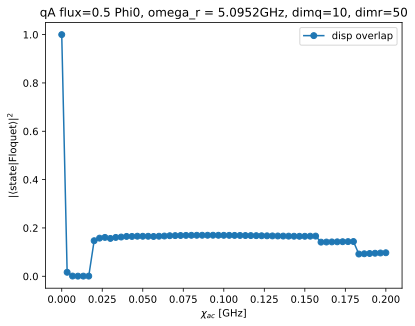

In [20]:
# plt.plot(chi_ac_vals/(2*np.pi), ov_bare**2, linestyle='-', marker='o', label = 'bare overlap')
plt.plot(chi_ac_vals/(2*np.pi), ov_disp**2, linestyle='-', marker='o', label = 'disp overlap')
plt.xlabel(r"$\chi_{ac}$ [GHz]")
plt.ylabel(r"$|\langle \mathrm{state}|\mathrm{Floquet}\rangle|^2$")
plt.title(f"qA flux={flux_pt} Phi0, omega_r = {omega_d[0]/(2*np.pi):.4f}GHz, dimq={dim_q}, dimr={dim_r}")
plt.legend()
plt.savefig(os.path.join(out_today, f"qA_flux04_dimq10_dimr50_displaced_overlap_vs_chi_ac.png"))

In [23]:
qA_params = {
        "EJ": 4.167,
        "EC": 0.8308,
        "EL": 1.203,
        "flux": 0.5,
        "cutoff": 110,
    }
omega_r = 2*np.pi * 5.095
g_qr    = 2*np.pi * 0.026

chi_ac_vals = 2*np.pi * np.linspace(0, 0.2, 61)
omega_d_bare = omega_r
dim_q = 10
dim_r = 100
flux_pt = 0.5

qA_params["flux"] = flux_pt

options = ft.Options(
        fit_range_fraction=0.6,
        fit_cutoff=4,
        overlap_cutoff=  0.5,   #0.8,
        nsteps=30_000,
        num_cpus=3,
        save_floquet_modes=True,
    )

composite_cfg = CompositeSysConfig(
    qubit_params=qA_params,
        dim_q=dim_q,
        dim_r=dim_r,
        omega_r=omega_r,
        g=g_qr,
        coupling_op="n",
        resonator_quadrature="x",
    )

disp_shift_single, sweep_single = chi_vs_flx_param_sweep(
    qubit_params=qA_params,
        flux_grid=np.array([flux_pt]),
        dim_q=10,
        omega_r_GHz= 5.095,
        dim_r=30,
        g_qr_GHz=0.026,
        coupling_op = "n",
        evals_count=30,
        num_cpus=None,
        )
omega_d = omega_d_bare + 2 * np.pi * disp_shift_single

build = build_composite_model(
    composite_cfg,
    omega_d_values=np.atleast_1d(omega_d),
    chi_ac_values=chi_ac_vals,
    label_states=((0, 0), (1, 0)),
)

df = truncation_metric_amp_sweep(
    build,
    chi_ac_vals,
    omega_d=float(build.model.omega_d_values[0]),
    target_label=(0, 0),
    nsteps=30_000,
    ntimes=21,
    stride=1,       
    verbose=True,
)

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/1 [00:00<?, ?it/s]

 c:\Users\slab\anaconda3\envs\floquet\Lib\site-packages\scqubits\utils\misc.py: 236

[trunc sweep] idx=  0 chi/2pi=0.000000 GHz amp=0
[trunc sweep] idx=  1 chi/2pi=0.003333 GHz amp=1.29232
[trunc sweep] idx=  2 chi/2pi=0.006667 GHz amp=1.82762
[trunc sweep] idx=  3 chi/2pi=0.010000 GHz amp=2.23837
[trunc sweep] idx=  4 chi/2pi=0.013333 GHz amp=2.58465
[trunc sweep] idx=  5 chi/2pi=0.016667 GHz amp=2.88972
[trunc sweep] idx=  6 chi/2pi=0.020000 GHz amp=3.16553
[trunc sweep] idx=  7 chi/2pi=0.023333 GHz amp=3.41917
[trunc sweep] idx=  8 chi/2pi=0.026667 GHz amp=3.65524
[trunc sweep] idx=  9 chi/2pi=0.030000 GHz amp=3.87697
[trunc sweep] idx= 10 chi/2pi=0.033333 GHz amp=4.08669
[trunc sweep] idx= 11 chi/2pi=0.036667 GHz amp=4.28615
[trunc sweep] idx= 12 chi/2pi=0.040000 GHz amp=4.47674
[trunc sweep] idx= 13 chi/2pi=0.043333 GHz amp=4.65954
[trunc sweep] idx= 14 chi/2pi=0.046667 GHz amp=4.83543
[trunc sweep] idx= 15 chi/2pi=0.050000 GHz amp=5.00515
[trunc sweep] idx= 16 chi/2pi=0.053333 GHz amp=5.16929
[trunc sweep] idx= 17 chi/2pi=0.056667 GHz amp=5.32839
[trunc sweep] id

In [26]:
df["comm_error_op_avg_first"] = df["comm_error_op_avg"].apply(
    lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x
)
df.to_csv("01252026_composite_analysis/qA_flux05_dimq10_dimr100_truncation_metrics_vs_chi_ac.csv", index=False)


In [25]:
dim_r

100

In [27]:
def plot_amp_metrics(df: pd.DataFrame, flux = flux_pt, dim_q = dim_q, dim_r = dim_r, *, x: str = "chi_ac_GHz", outdir: Optional[str] = None):
    cmap = "viridis"
    c = df[x]
    
    # 1. commutator infidelity
    fig, ax = plt.subplots(figsize=(7, 4))
    sc = ax.scatter(df[x], df["comm_error_op_avg"], c=df["comm_error_op_avg"], cmap=cmap, s=10, lw=0.5)
    
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(r"|$\rm{Tr}[\rho([a,a^\dagger]-I)]|$")
    ax.set_xlabel(x)
    ax.set_ylabel(r"|$\rm{Tr}[\rho([a,a^\dagger]-I)]|$")
    ax.set_title(f"Commutator infidelity, dim_r = {dim_r}, dim_q = {dim_q}, flux = {flux} Phi0")
    plt.tight_layout()
    plt.show()
    if outdir is not None:
        save_figure(fig, os.path.join(outdir, f"dimq{dim_q}_dimr{dim_r}_commutator_infidelity_vs_chi_ac_flux_{flux}.png"))
    
    # 2. avg photon number
    fig, ax = plt.subplots(figsize=(7, 4))
    sc = ax.scatter(df[x], df["Nr_avg"], c=df["Nr_avg"], cmap=cmap, s=10, lw=0.5)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(r"$\langle N_r\rangle$ (avg)")
    ax.set_xlabel(x)
    ax.set_ylabel(r"$\langle N_r\rangle$ (avg)")
    ax.set_title(f"Average photon number, dim_r = {dim_r}, dim_q = {dim_q}, flux = {flux} Phi0")
    plt.tight_layout()
    plt.show()
    if outdir is not None:
        save_figure(fig, os.path.join(outdir, f"dimq{dim_q}_dimr{dim_r}_average_photon_number_vs_chi_ac_flux_{flux}.png"))
    
    # 3. weight at truncation boundary
    # fig, ax = plt.subplots(figsize=(7, 4))
    # sc = ax.scatter(df[x], df["p_r_top_avg"], c=df["p_r_top_avg"], cmap=cmap, s=10, lw=0.5)
    # cbar = plt.colorbar(sc, ax=ax)
    # cbar.set_label(r"$p_{\mathrm{top}}$ (avg)")
    # ax.set_xlabel(x)
    # ax.set_ylabel(r"$p_{\mathrm{top}}$ (avg)")
    # ax.set_title(f"Weight at truncation boundary (resonator), dim_r = {dim_r}, dim_q = {dim_q}, flux = {flux} Phi0")
    # plt.tight_layout()
    # plt.show()
    # if outdir is not None:
    #     save_figure(fig, os.path.join(outdir, f"dimq{dim_q}_dimr{dim_r}_weight_at_truncation_boundary_vs_chi_ac_flux_{flux}.png"))

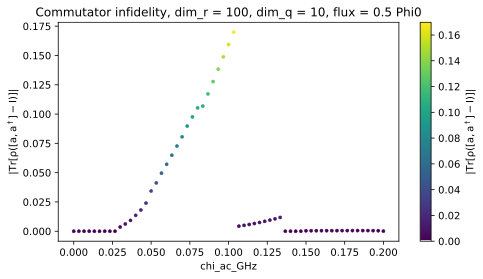

Saved figure: 01252026_composite_analysis\dimq10_dimr100_commutator_infidelity_vs_chi_ac_flux_0.5.png


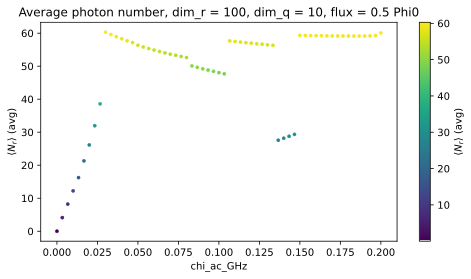

Saved figure: 01252026_composite_analysis\dimq10_dimr100_average_photon_number_vs_chi_ac_flux_0.5.png


In [28]:
plot_amp_metrics(df, flux=flux_pt, dim_q=dim_q, dim_r=dim_r, x="chi_ac_GHz", outdir="01252026_composite_analysis")

In [49]:
# index = 1
# chi_small = chi_ac_vals[index]              # first nonzero
# amp_small = float(build.model.drive_amplitudes[index, 0])
# omega_d_scalar = float(build.model.omega_d_values[0]) 
# for i in range(chi_ac_vals.shape[0]):
# m = floquet_metrics_single_pt(build, omega_d=omega_d_scalar, amp=build.model.drive_amplitudes[0], target_label=(0,0))
# # print("Purity_avg:", m["purity_avg"])
# # print("Entanglement Entropy_avg:", m["entropy_avg"])
# # print("Nr_avg:", m["Nr_avg"])
# # print("comm_err:", m["commutator_error_avg"])
# # print("p_q_top_avg:", m["p_q_top_avg"])

In [48]:
chi_ac_vals.shape[0]

61

In [152]:

print("drive amplitude:", build.model.drive_amplitudes[index,0])
print("chi_ac [GHz]", chi_ac_vals[index]/(2*np.pi))
print("photon number:", (chi_ac_vals[index]/disp_shift_single)/(2*np.pi))

drive amplitude: 2.5027066338459534
chi_ac [GHz] 0.01
photon number: [-30.83251511]


In [5]:
scar_flux, omega_used = flux_sweep_composite_scar(
        cfg=composite_cfg,
        flux_grid=flux_grid,
        chi_ac_values=chi_ac_vals,
        omega_d_bare=omega_d_bare,
        chi_v_flux_GHz=disp_shift,
        label_states=((0, 0), (1, 0)),
        options=options,
        state_slot_to_plot=1,
        verbose=True,
        outdir="scar_flux_sweep_02_03Phi0_qA_dq10_dr10_composite",
    )

[flux sweep] i=  0/40  flux=0.20000  omega_d/2pi=5.088173
calculating for amp_range_idx=0
calculating for amp_range_idx=1
finished in 0.7312277436256409 minutes
[flux sweep] i=  1/40  flux=0.20250  omega_d/2pi=5.088691
calculating for amp_range_idx=0
calculating for amp_range_idx=1
finished in 0.6762401461601257 minutes
[flux sweep] i=  2/40  flux=0.20500  omega_d/2pi=5.089138
calculating for amp_range_idx=0
calculating for amp_range_idx=1
finished in 0.6763010144233703 minutes
[flux sweep] i=  3/40  flux=0.20750  omega_d/2pi=5.089524
calculating for amp_range_idx=0
calculating for amp_range_idx=1
finished in 0.6770289738972982 minutes
[flux sweep] i=  4/40  flux=0.21000  omega_d/2pi=5.089856
calculating for amp_range_idx=0
calculating for amp_range_idx=1
finished in 0.6745043198267618 minutes
[flux sweep] i=  5/40  flux=0.21250  omega_d/2pi=5.090139
calculating for amp_range_idx=0
calculating for amp_range_idx=1
finished in 0.6986135681470235 minutes
[flux sweep] i=  6/40  flux=0.2150

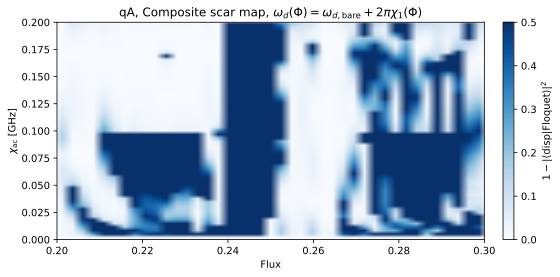

(<Figure size 800x400 with 2 Axes>,
 <Axes: title={'center': 'qA, Composite scar map, $\\omega_d(\\Phi)=\\omega_{d,\\mathrm{bare}}+2\\pi\\chi_1(\\Phi)$'}, xlabel='Flux', ylabel='$\\chi_{\\rm ac}$ [GHz]'>)

In [6]:
def chiac_to_photon_number(chi_ac_vals_GHz, chi_01_vals_GHz):
    chi_ac_vals_GHz = np.asarray(chi_ac_vals_GHz)
    chi_01_vals_GHz = np.asarray(chi_01_vals_GHz)
    n_r = chi_ac_vals_GHz / (2 * chi_01_vals_GHz)
    return n_r

plot_scar_map(
        scar_flux,
        x_vals=flux_grid,
        y_vals=chi_ac_vals/(2*np.pi),
        x_label="Flux",
        y_label=r"$\chi_{\rm ac}$ [GHz]",
        title=r"qA, Composite scar map, $\omega_d(\Phi)=\omega_{d,\mathrm{bare}}+2\pi\chi_1(\Phi)$",
        cmap="Blues",
        vmin=0.0,
        vmax=0.5,
    )

In [8]:
scar_flux

array([[0.        , 0.01053164, 0.00812282, ..., 0.00182538, 0.002285  ,
        0.00277126],
       [0.        , 0.03340357, 0.02062827, ..., 0.03177392, 0.0459718 ,
        0.06389698],
       [0.        , 0.09571836, 0.17925973, ..., 0.01714577, 0.02424613,
        0.0331453 ],
       ...,
       [0.        , 0.5       , 0.5       , ..., 0.05949556, 0.05889663,
        0.06804272],
       [0.        , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.        , 0.5       , 0.5       , ..., 0.07422753, 0.09445741,
        0.1170932 ]], shape=(41, 61))

In [7]:
#test
data = run_floquet_analysis_composite(build, options=options)

ov_bare = np.abs(np.asarray(data["bare_state_overlaps"][0, :, 1])) 
ov_disp = np.abs(np.asarray(data["displaced_state_overlaps"][0, :, 1]))

print("bare overlap at first 5 amps:", ov_bare[:5])
print("disp overlap at first 5 amps:", ov_disp[:5])
print("scar at first 5 amps:", (1 - ov_disp[:5]**2))


NameError: name 'build' is not defined

In [22]:
flux_point = 0.22
qA_params['flux'] = flux_point
cfg_single = CompositeSysConfig(
        qubit_params=qA_params,
        dim_q=dim_q,
        dim_r=dim_r,
        omega_r=omega_r,
        g=g_qr,
        coupling_op="n",
        resonator_quadrature="x",
    )
comp_point = build_composite_model(
        cfg_single, chi_ac_values=chi_ac_vals, omega_d_values=np.array([omega_d_bare]), label_states=((0, 0), (1, 0)),
    )
branch_analysis_single = branch_analysis_composite(
        build=comp_point,
        chi_ac_values=chi_ac_vals,
        omega_d=omega_d_bare,
        nsteps=30_000,
        t_sample_fraction=0.0,
        max_branches=60,
        label_confidence_threshold=0.25,
        compute_purity=True,
        outdir="branch_analysis_flux022_Phi0_qA_dq10_dr10_composite",
    )

KeyboardInterrupt: 